In [57]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from fitter import Fitter
from scipy import signal
from pandas.plotting import autocorrelation_plot
from pmdarima.arima import ADFTest
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
sns.set_style('darkgrid')
# from sklearn.impute import SimpleImputer
# import arviz as az
# import pymc3 as pm
# from theano import tensor as tt
# from fitter import Fitter, get_common_distributions, get_distributions
# import mean_squared_error
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tools.tools import add_constant
# from sklearn.metrics import accuracy_score,confusion_matrix
# from pandas.plotting import lag_plot
# from pmdarima.arima import auto_arima
%matplotlib inline
# fix this issue
shap.initjs


#type hints
#shap plots

<function shap.plots._force.initjs()>

In [35]:
os.chdir('G:/My Drive/To_Do/MMM/Raw_Hain_Data')

In [36]:
dm = pd.read_csv('deutsch_matterkind.csv', low_memory=False)
ts = pd.read_csv('Celestial_Trade_Spend_5_22.csv')
cd = pd.read_csv('celestial_data_16_22_22.csv')
dm_pivot = pd.read_csv('dm_Robyn.csv')

In [37]:
df = dm_pivot
print(df)

          DATE  audio_S   audio_I  onlinedisplay_S  onlinedisplay_I  \
0    3/28/2021  13193.0  573044.0            16539          1441508   
1     4/4/2021   5654.0  245590.0            11046           917669   
2    4/11/2021   5284.0  190527.0             5979           456890   
3    4/18/2021   5627.0  205508.0             5727           440490   
4    4/25/2021   4849.0  179395.0             5005           391257   
5     5/2/2021   4106.0  149209.0             4566           347095   
6     5/9/2021   4788.0  169530.0             5991           467989   
7    5/16/2021   4271.0  169451.0             5606           441726   
8    5/23/2021   5459.0  224790.0             5083           414955   
9    5/30/2021   2254.0   94336.0             4053           365003   
10    6/6/2021   4544.0  184465.0             9497           892804   
11   6/13/2021   5008.0  206610.0            10050           950490   
12   6/20/2021   2345.0   95231.0             4741           457753   
13   6

In [38]:
def missing_values(df):
    segment = [var for var in df.columns if df[var].dtype == 'O']
    print('There are {} variables\n'.format(len(segment)))
    print('The variables are :\n\n', segment)
    print('The percentage missing of each of the variables is:\n')
    print(df[segment].isnull().sum() * 100/ len(df))
    print('The count of non-nulls for each of the variables is:\n')
    missing = df.select_dtypes(include=object)
    missing.info()

In [39]:
def dickey_fuller(df):
    adf_test = ADFTest(alpha = .05)
    print('Because the ADF is smaller than the given alpha, the null hypothesis is false,'
          'and it is most likely not stationery.')
    result = adf_test.should_diff(df['revenue'])
    return result

In [40]:
def unique(df):
    segment = [var for var in df.columns if df[var].dtype == 'O']
    print('There are {} numerical/continuous variables\n'.format(len(segment)))
    print('The numerical/continuous variables are :\n\n', segment)
    print(df[segment].isnull().sum() / len(df))
    df.info()
    df.describe()
    print(df.nunique())

In [41]:
def summary(df):
    print(missing_values(df))
    print(dickey_fuller(df))
    print(unique(df))

In [42]:
summary(df)

There are 1 variables

The variables are :

 ['DATE']
The percentage missing of each of the variables is:

DATE    0.0
dtype: float64
The count of non-nulls for each of the variables is:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    45 non-null     object
dtypes: object(1)
memory usage: 488.0+ bytes
None
Because the ADF is smaller than the given alpha, the null hypothesis is false,and it is most likely not stationery.
(0.043462147391171393, False)
There are 1 numerical/continuous variables

The numerical/continuous variables are :

 ['DATE']
DATE    0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DATE             45 non-null     object 
 1   audio_S          13 non-null     floa

In [43]:
df = df.drop(['audio_S', 'audio_I', 'ott_I', 'ott_S',
              'tiktok_I', 'tiktok_S', 'onlinedisplay_S', 'onlinedisplay_I'], axis=1)
df.nunique()

DATE             45
onlinevideo_S    29
onlinevideo_I    29
paidsearch_S     30
paidsearch_I     30
social_S         35
social_I         35
revenue          41
dtype: int64

Attempt to fix this

Understand what the numbers mean and at which level their dangerous,

,revenue,onlinevideo_I,onlinevideo_S,paidsearch_I,paidsearch_S,social_I,social_S
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,0.807143,0.628571,0.520000,0.704286,0.674286,0.710000,0.738571
std,0.154673,0.226821,0.294675,0.250989,0.267261,0.271846,0.227481
min,0.550000,0.420000,0.260000,0.320000,0.260000,0.260000,0.410000
25%,0.730000,0.460000,0.290000,0.570000,0.540000,0.570000,0.590000
50%,0.790000,0.500000,0.410000,0.720000,0.680000,0.700000,0.720000
75%,0.925000,0.780000,0.695000,0.875000,0.850000,0.935000,0.930000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


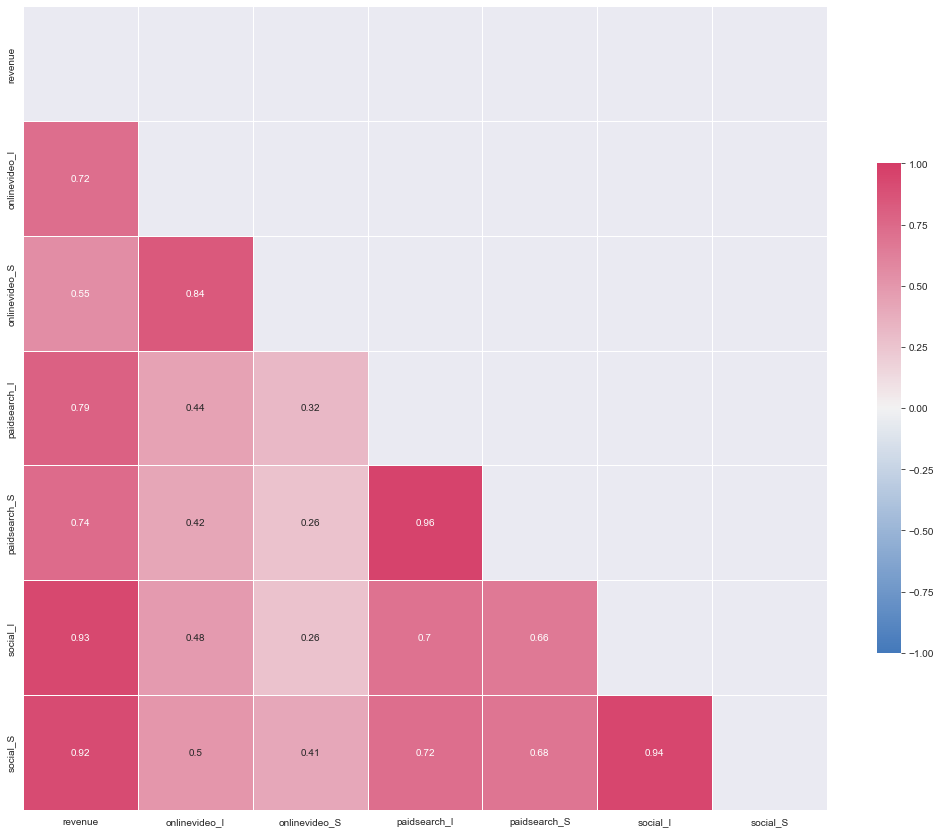

In [52]:
temp_dm = df[['revenue', 'onlinevideo_I', 'onlinevideo_S',
              'paidsearch_I', 'paidsearch_S', 'social_I', 'social_S']]
corr = temp_dm.corr(method="spearman").round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(250, 1, as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr.describe()

Find something useful for the next two sections, especially considering synthetic data

<AxesSubplot:xlabel='social_I', ylabel='Density'>

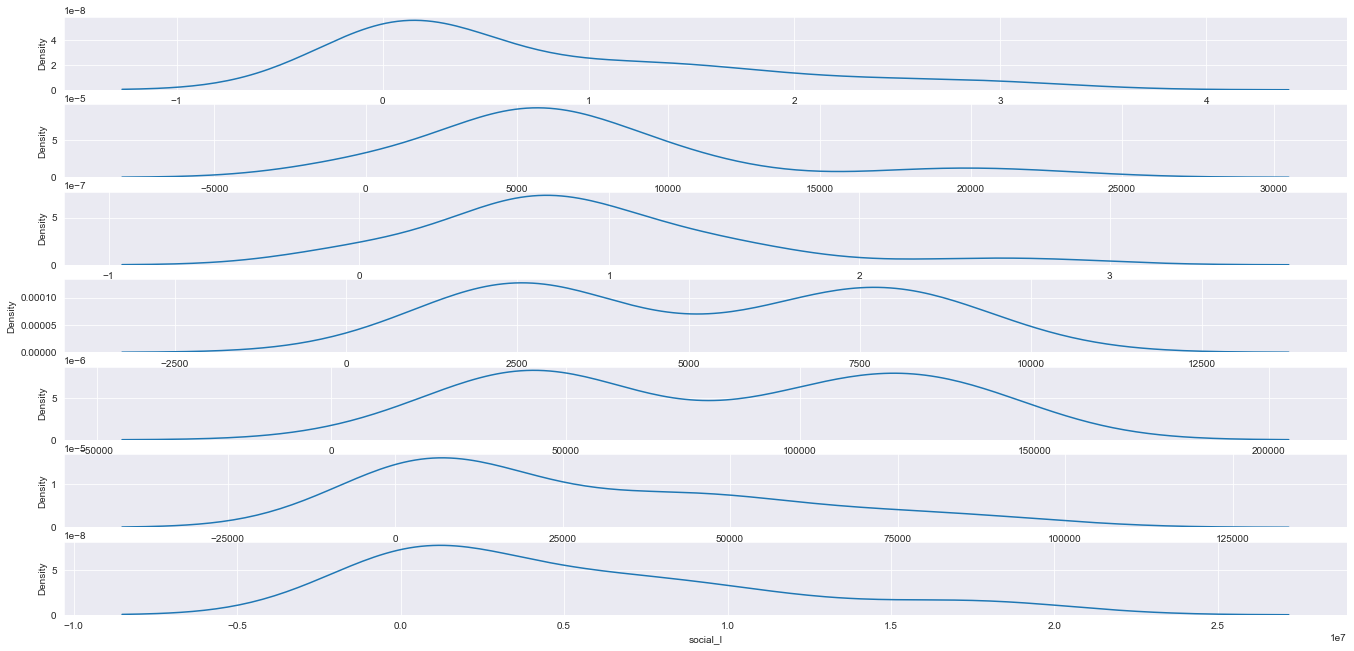

In [48]:
figure, axes = plt.subplots(7, 1, figsize=(23, 11))
sns.kdeplot(ax=axes[0], x='revenue', data=df)
sns.kdeplot(ax=axes[1], x='onlinevideo_S', data=df)
sns.kdeplot(ax=axes[2], x='onlinevideo_I', data=df)
sns.kdeplot(ax=axes[3], x='paidsearch_S', data=df)
sns.kdeplot(ax=axes[4], x='paidsearch_I', data=df)
sns.kdeplot(ax=axes[5], x='social_S', data=df)
sns.kdeplot(ax=axes[6], x='social_I', data=df)

Selecting from the most likely distributions of the data,
finds the most likely distribution for the data, its parameters,
and is useful for any data transformations.

In [53]:
temp_dm = df[['revenue', 'onlinevideo_I', 'onlinevideo_S',
              'paidsearch_I', 'paidsearch_S', 'social_I', 'social_S']]
dist_list = ['gamma', 'expon', 'cauchy', 'norm', 'uniform']

for var in temp_dm:
    dist_test = temp_dm[var].dropna()
    dist_test = dist_test.values
    f = Fitter(dist_test, distributions=dist_list, timeout=60)
    f.fit()
    print(var)
    print(f.summary(plot=False))
    print(f.get_best(method='sumsquare_error'))

revenue
         sumsquare_error          aic          bic  kl_div
gamma       3.285597e-13  3978.761049 -1453.362421     inf
expon       6.876800e-13  3587.623354 -1423.931861     inf
cauchy      7.013429e-13  3797.035645 -1423.046562     inf
norm        8.461192e-13  3574.951086 -1414.601715     inf
uniform     8.578153e-13  3456.160352 -1413.983930     inf
{'gamma': {'a': 0.2541383466522374, 'loc': -3.7891205254781435e-21, 'scale': 6313709.556282228}}
onlinevideo_I
         sumsquare_error          aic         bic  kl_div
cauchy      6.328032e-11  3157.596171 -799.736927     inf
gamma       6.729615e-11  3063.009804 -794.489871     inf
norm        6.770160e-11  3086.673323 -797.710866     inf
expon       7.141584e-11  3054.165220 -796.108571     inf
uniform     7.391521e-11  2970.787370 -795.076601     inf
{'cauchy': {'loc': 732262.6360080556, 'scale': 243362.52507049876}}
onlinevideo_S
         sumsquare_error          aic         bic  kl_div
cauchy      6.808150e-07  2231.837357 -

Interpret this

In [ ]:
detrended = signal.detrend(df['revenue'].values)
plt.rcParams.update({'figure.figsize': (18,6)})
plt.plot(detrended)
plt.title('Sales Detrended', fontsize=16)

Multiplicative seasonality deconstruction does not work here with the high levels of zeroes in the data, see if we can use after
imputation

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

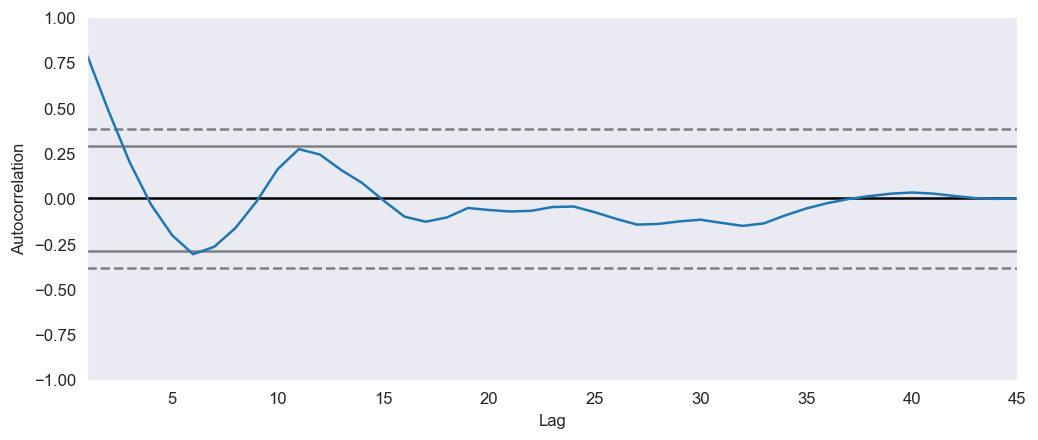

In [54]:
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':120})
autocorrelation_plot(df['revenue'].tolist())

In [ ]:
df.to_csv('.csv', encoding='utf-8', index=False)

This appear to be a mix of KNN and Mice imputation. Figure that out and find one more basic method and one more complicated

In [56]:
# KNN Imputation
df_knn = df.filter(['revenue', 'onlinevideo_I', 'onlinevideo_S',
              'paidsearch_I', 'paidsearch_S', 'social_I', 'social_S'], axis=1).copy()

# Define scaler to set values between 0 and 1

scaler = MinMaxScaler(feature_range=(0, 1))
df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)

# Define KNN imputer and fill missing values
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)

Read through shap documentation, figure out how to better visualize and analyze data

In [ ]:
model = xgb.XGBRegressor(n_estimators=1000, tree_method="gpu_hist").fit(X_train, y_train)
preds = model.predict(X_valid)
rmse = mean_squared_error(y_valid, preds, squared=False)

In [58]:
# Mice Imputation
df_mice = df.filter(['revenue', 'onlinevideo_I', 'onlinevideo_S',
              'paidsearch_I', 'paidsearch_S', 'social_I', 'social_S'], axis=1).copy()
#check estimator, n_nearest_features, imputation_order
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)